In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


PATTERN1: 65.47085201793722
PATTERN2: 66.81614349775785
PATTERN3: 61.43497757847533
PATTERN4: 72.19730941704036
PATTERN5: 61.88340807174888
PATTERN6: 78.9237668161435
PATTERN7: 77.57847533632287
PATTERN8: 68.16143497757848
PATTERN9: 61.88340807174888
PATTERN10: 69.5067264573991
PATTERN11: 72.19730941704036
PATTERN12: 75.33632286995515
PATTERN13: 71.30044843049328
PATTERN14: 68.16143497757848
PATTERN15: 65.91928251121077
PATTERN16: 74.88789237668162
PATTERN17: 77.13004484304933
PATTERN18: 69.05829596412556


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


accuracy = 0.6278026905829597


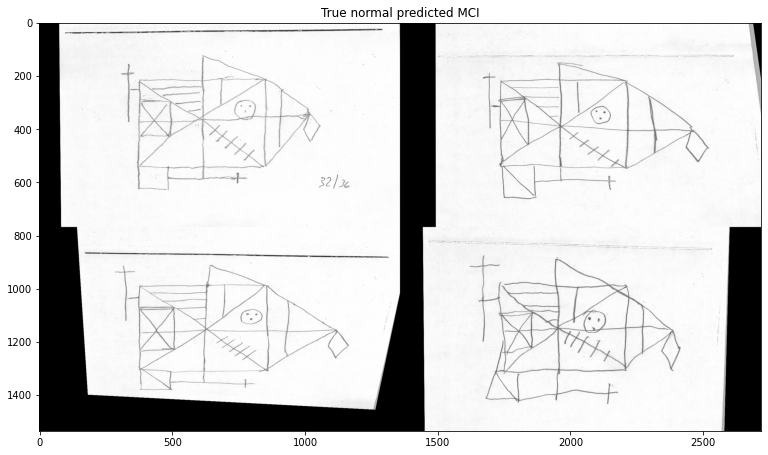

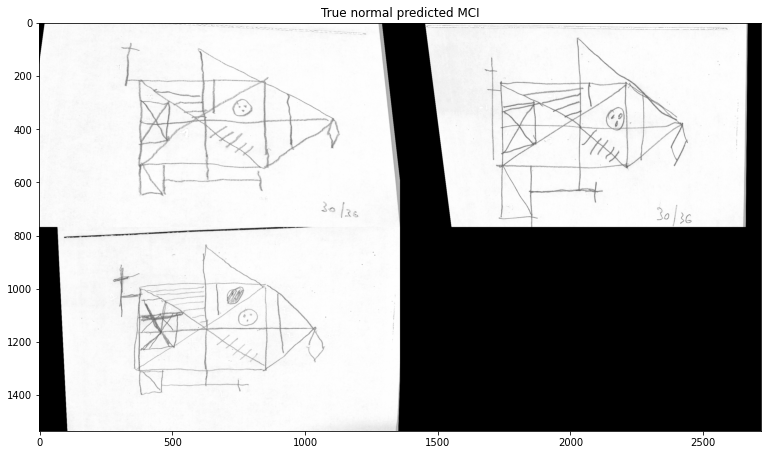

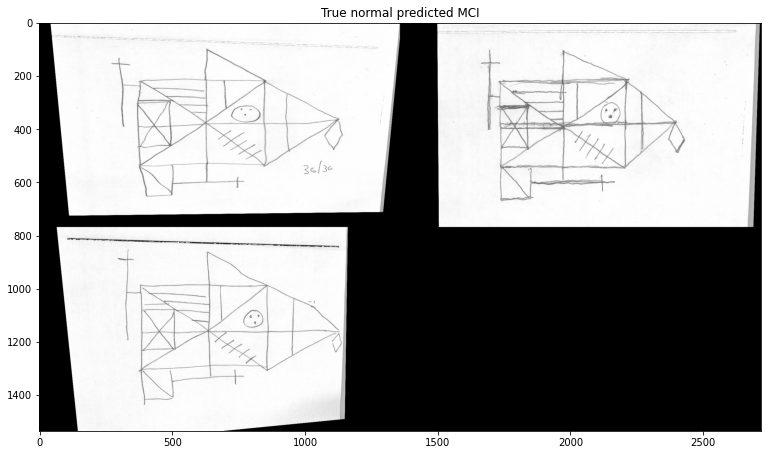

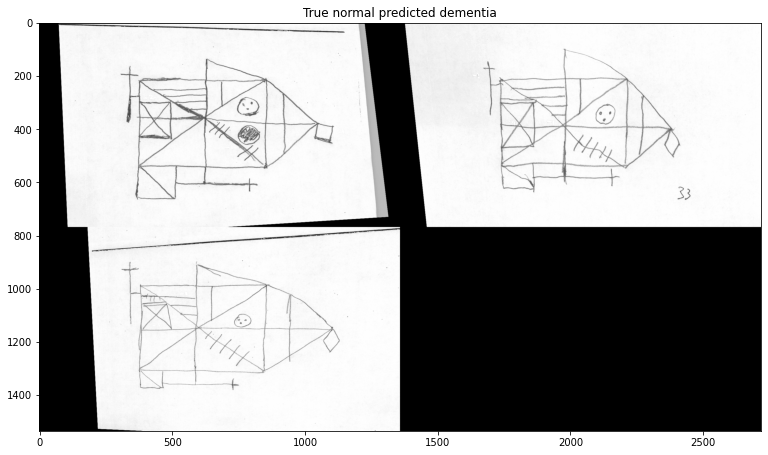

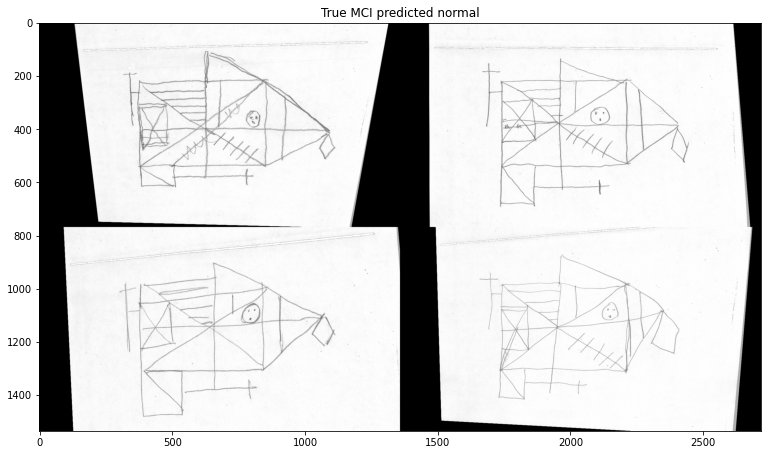

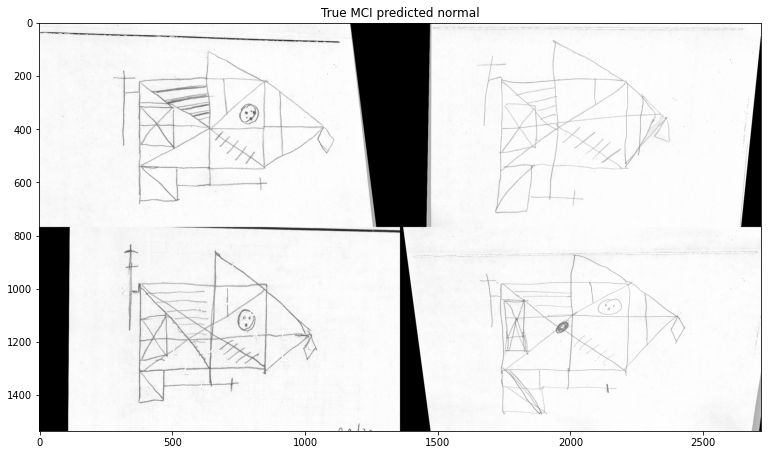

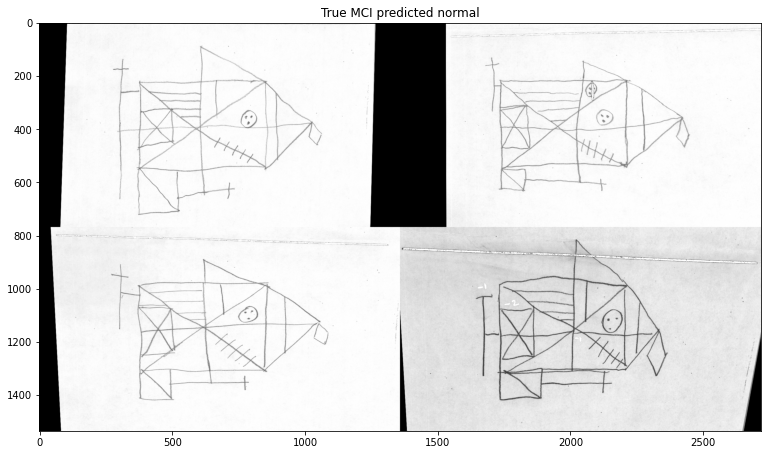

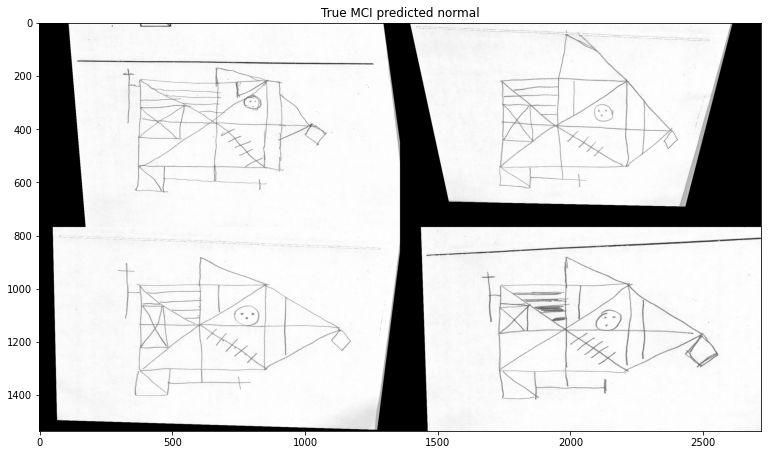

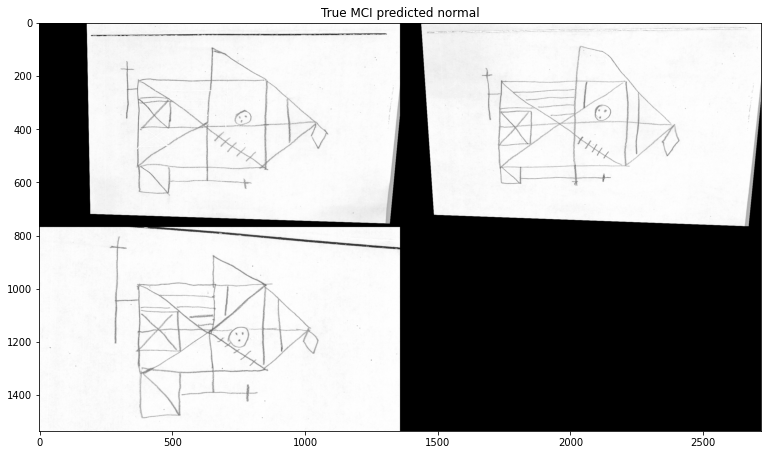

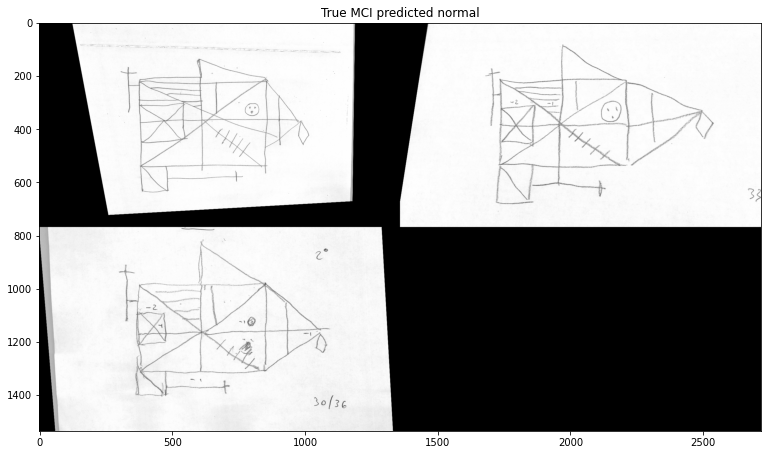

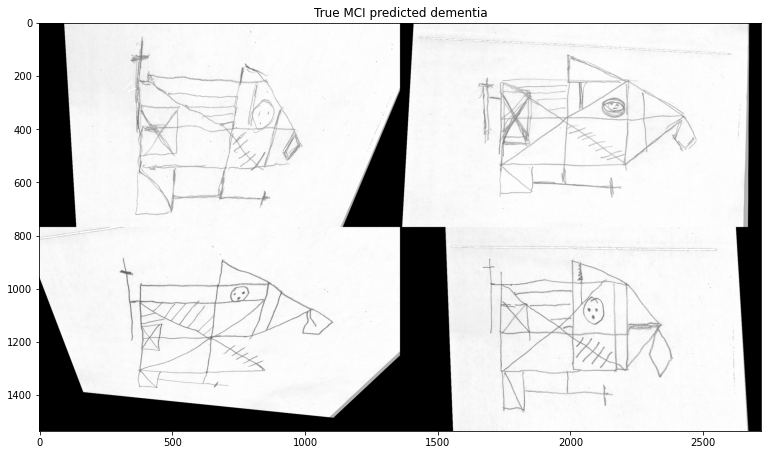

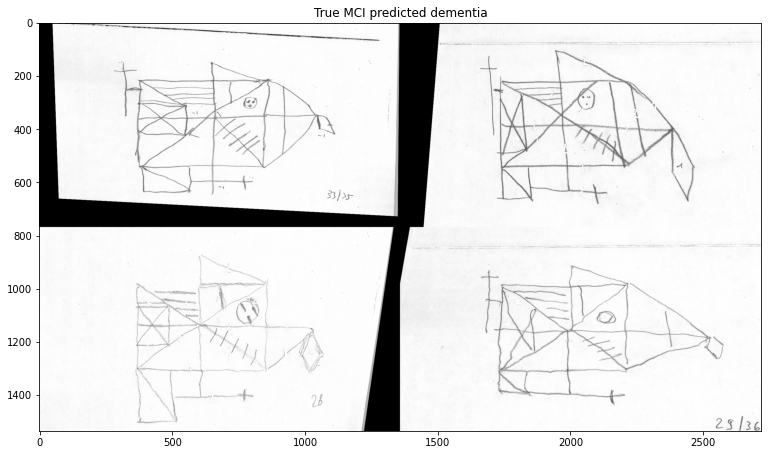

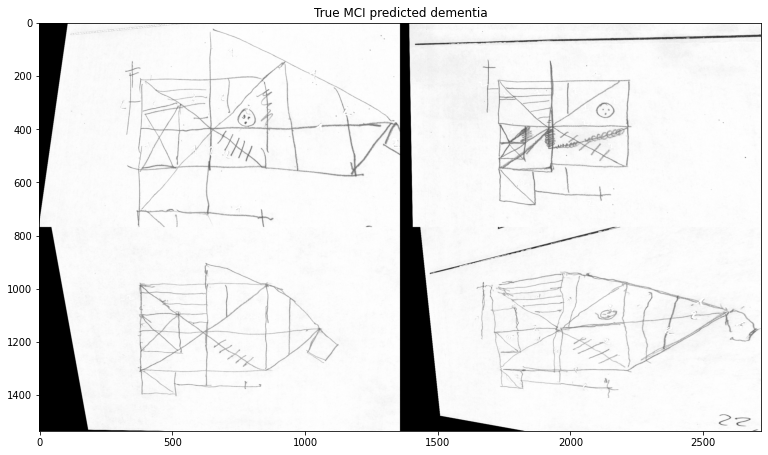

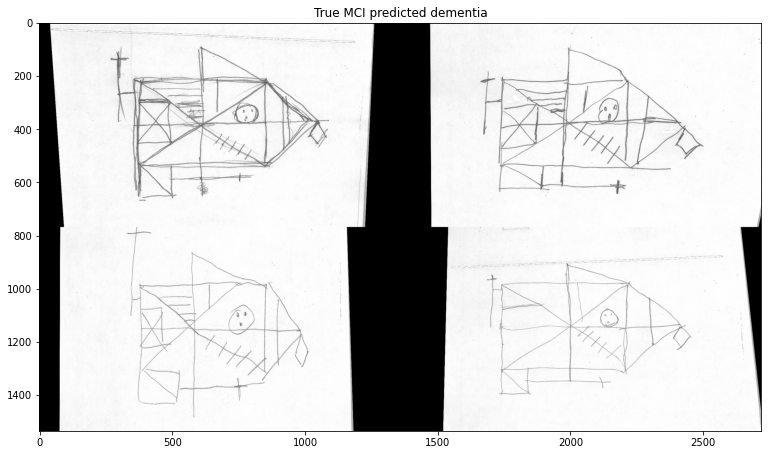

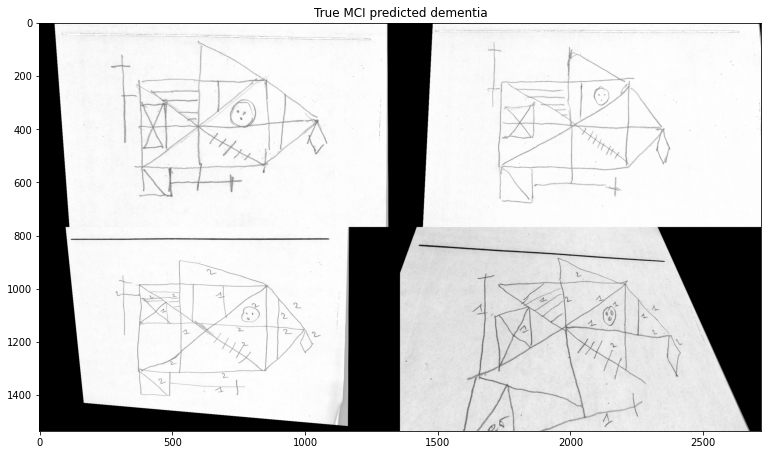

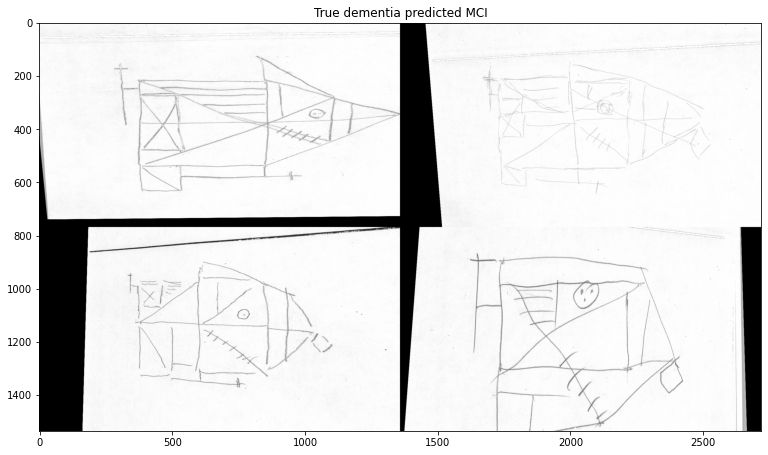

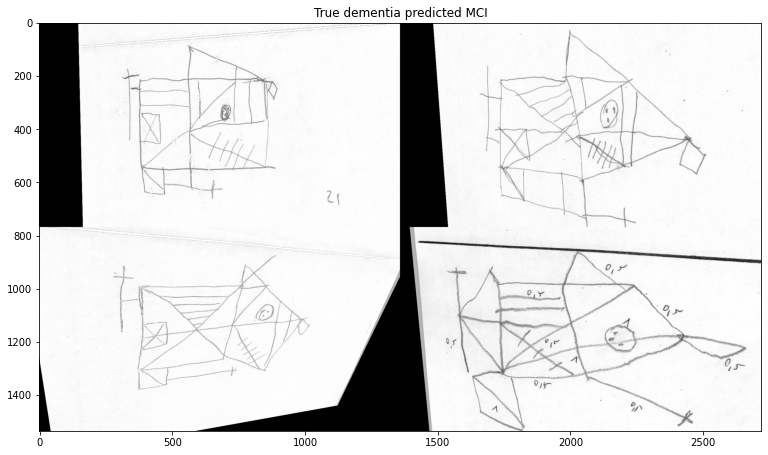

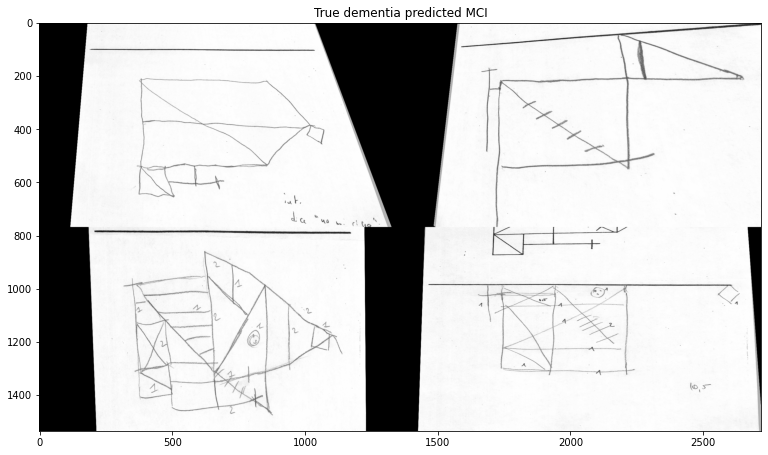

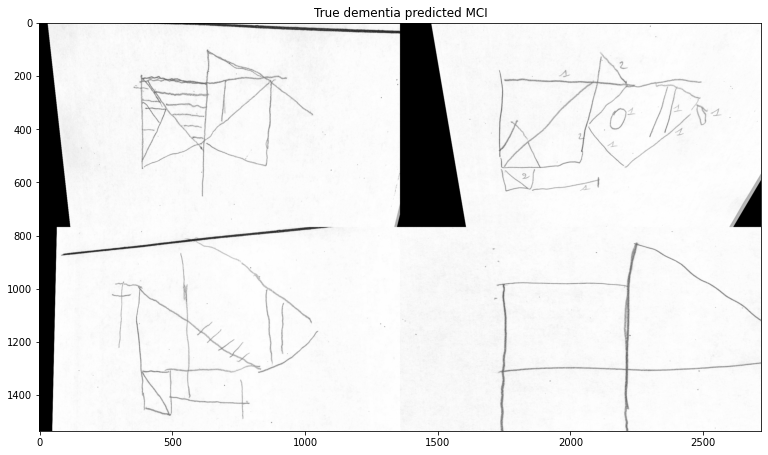

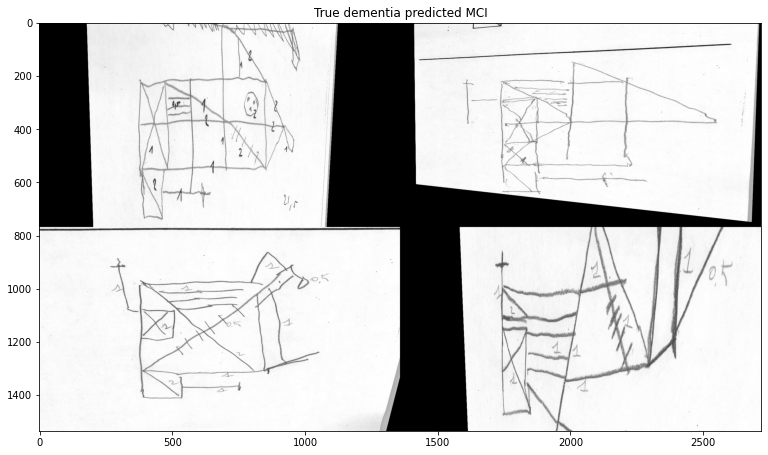

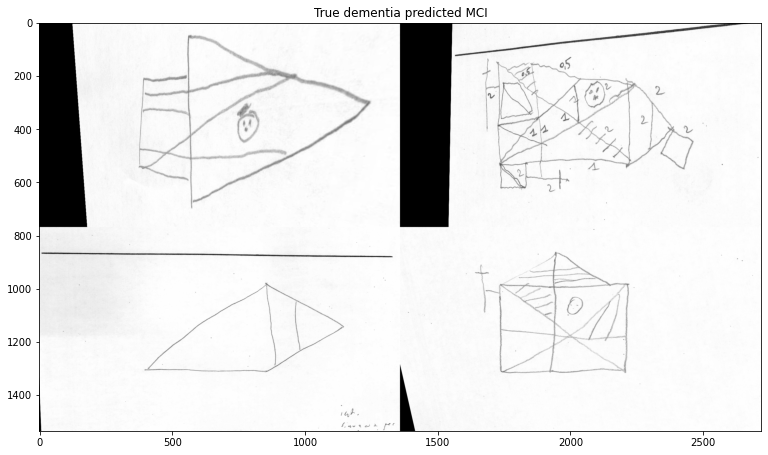

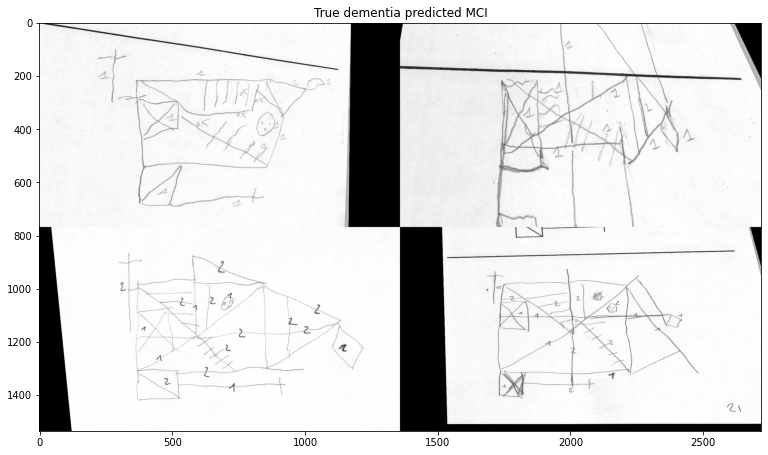

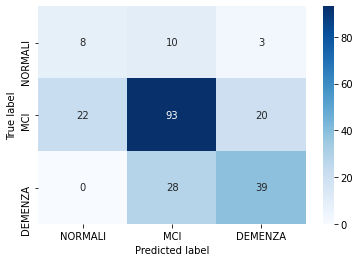

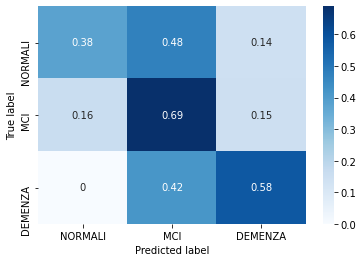

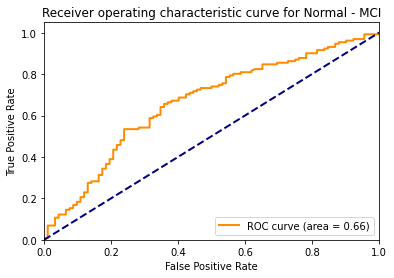

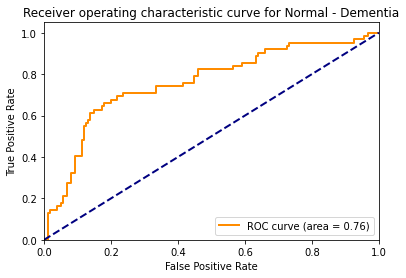

accuracy = 0.757847533632287
0


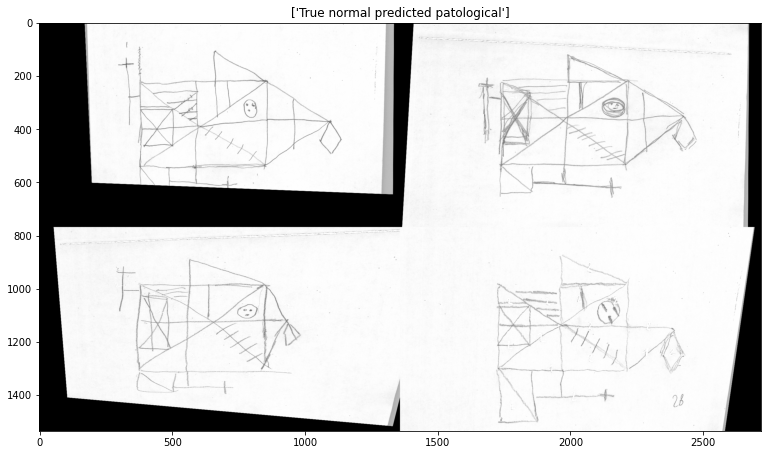

0


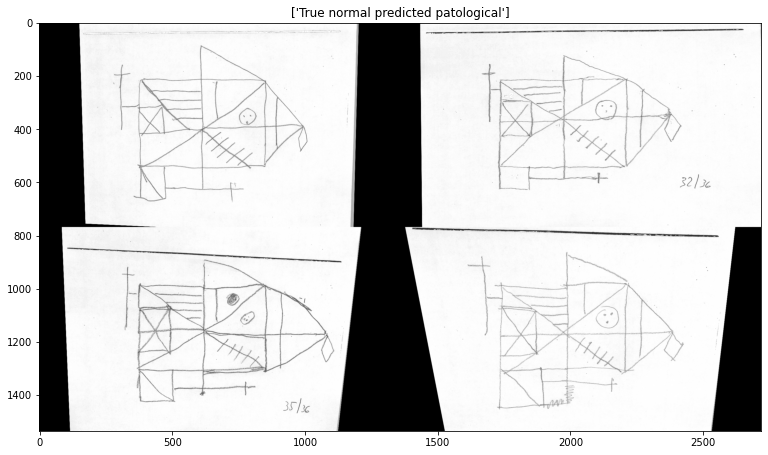

0


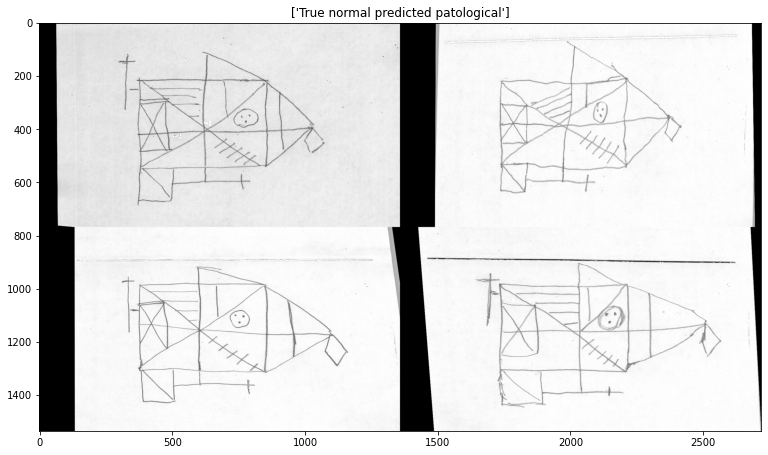

0


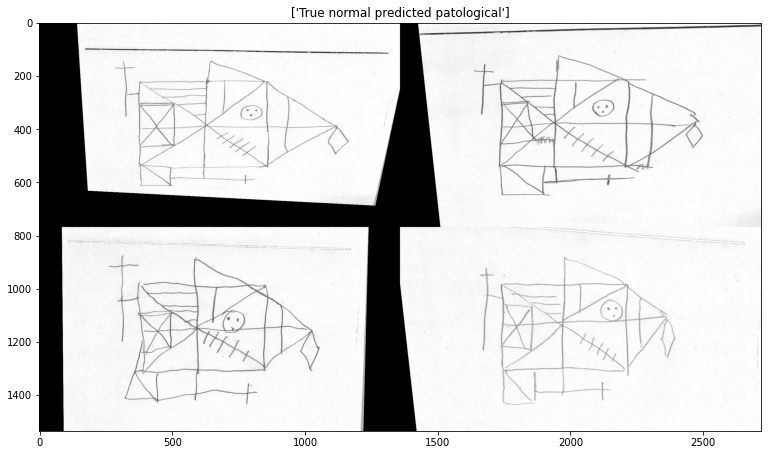

0


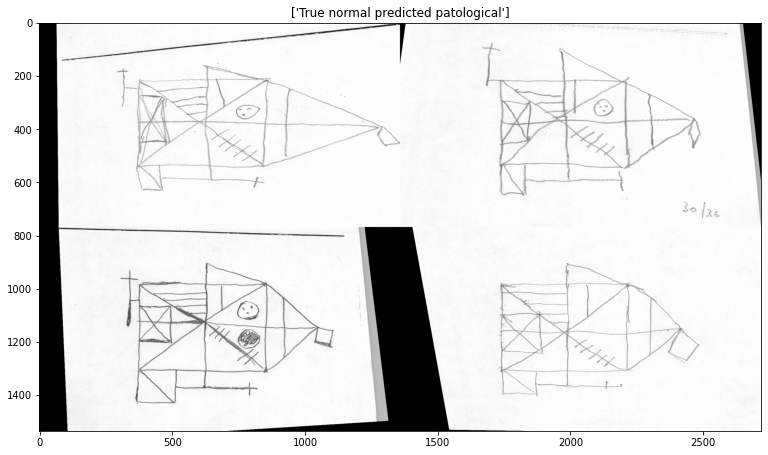

0


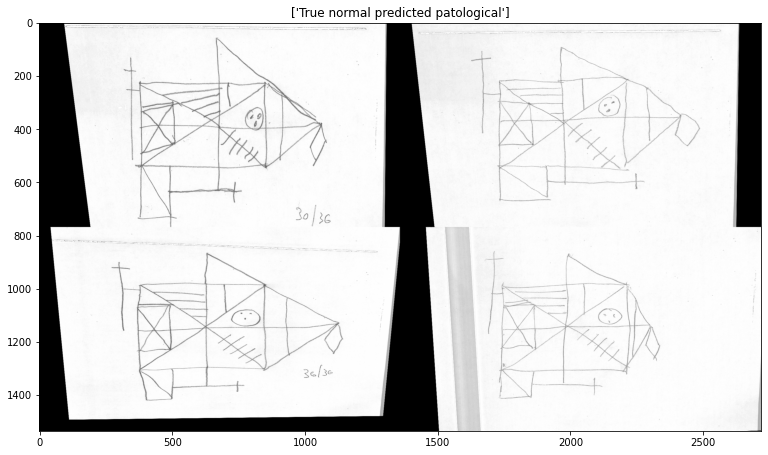

0


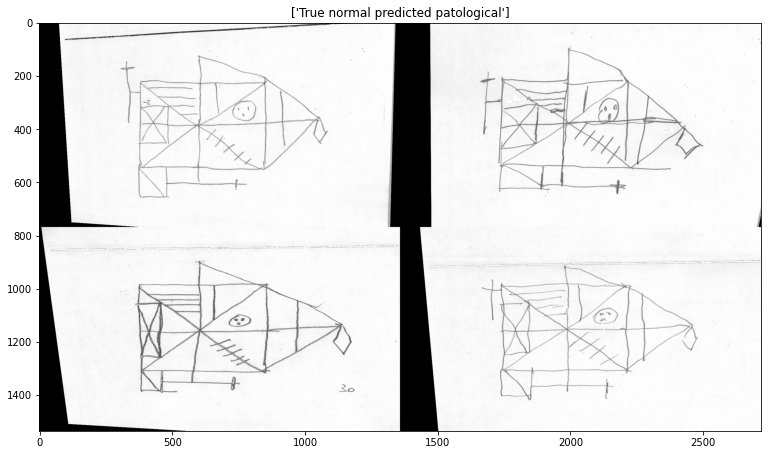

0


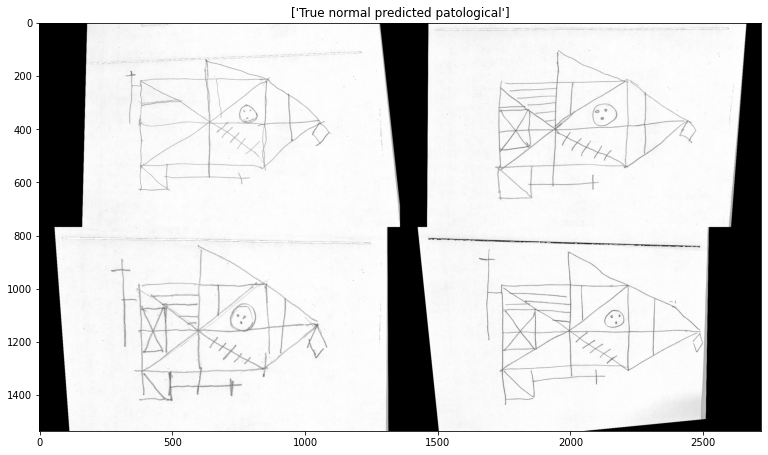

0


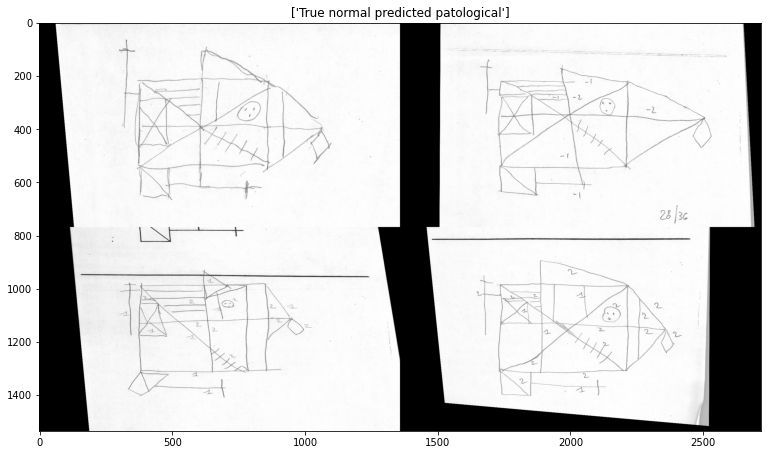

1


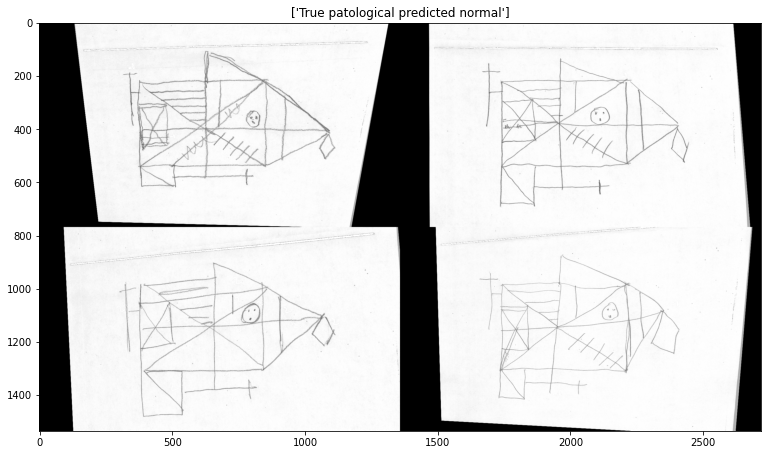

1


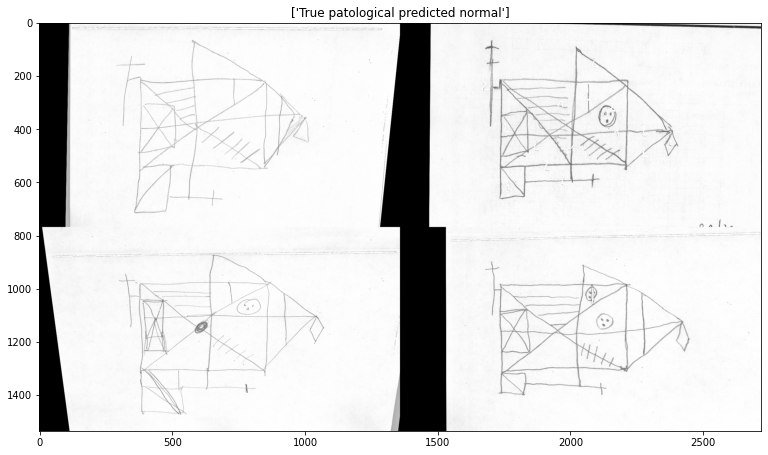

1


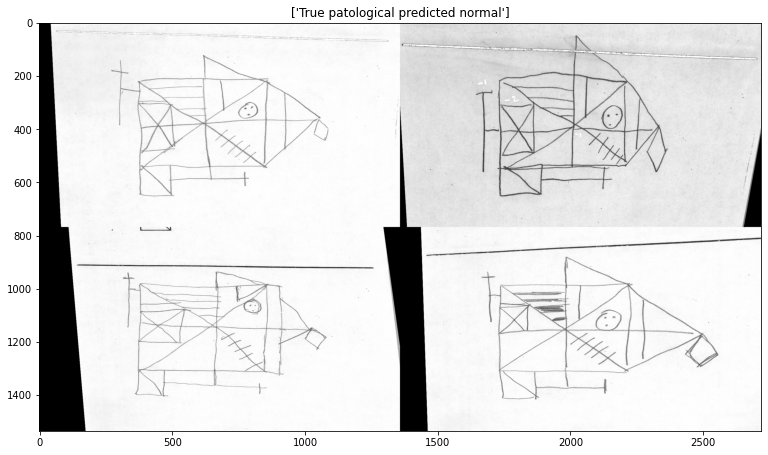

1


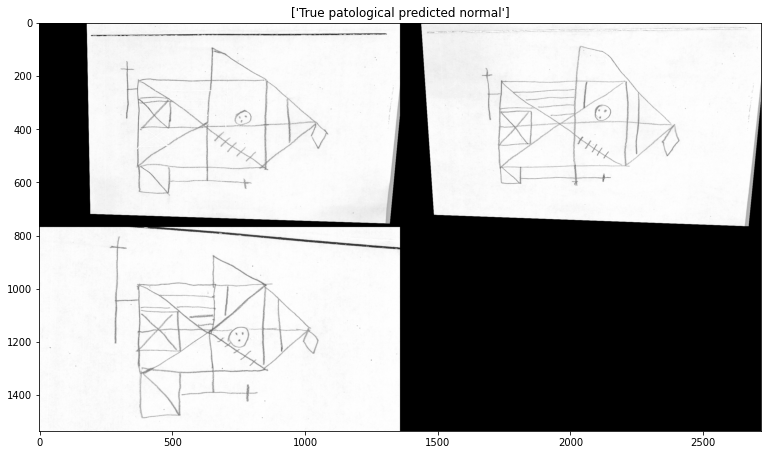

1


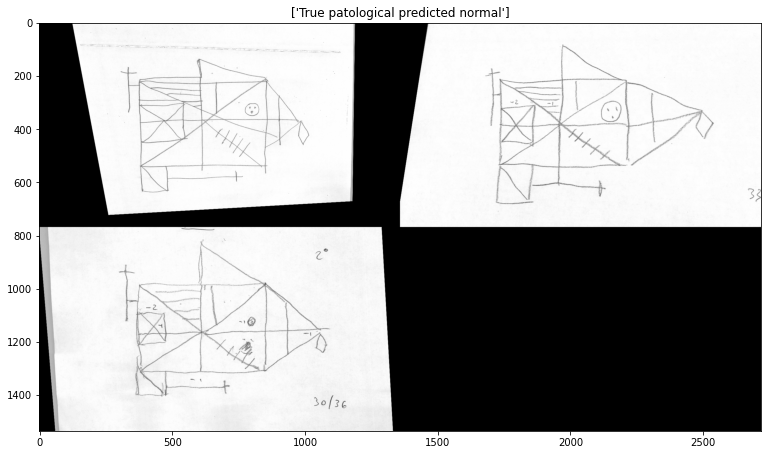

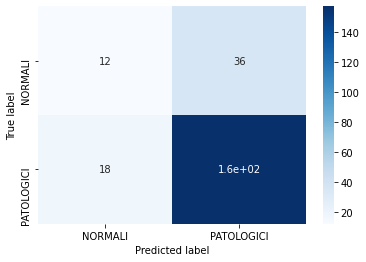

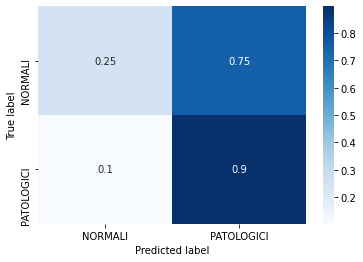

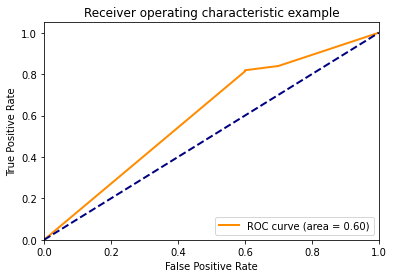

In [2]:
'''from results of the pattern scoring system, compute the diagnosys with a 3-class 
model (SVM) and a 2 class model (Decision Tree).
Show also those drawing with wrong classification
'''
import os
import pandas as pd
import joblib
import numpy as np
from seaborn import heatmap
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from matplotlib import pyplot as plt
import cv2
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def label_3(s):
    if s == 'NORMALI':
        return 0
    if s == 'DEMENZA':
        return 2
    return 1

def label_2(s):
    if s == 'NORMALI':
        return 0
    return 1


root = 'gdrive/My Drive/thesis/' #modificare se cartella rinominata
labels = pd.read_csv(os.path.join(root, 'Database completo .csv'), header=0, index_col=0, delimiter=';')
results = pd.read_csv(os.path.join(root, 'miei_result.csv'), header=0, index_col=0)
for col in labels.columns[3:-1]:
  miei_score = results[col].to_numpy()
  dataset_scores = labels.loc[results.index][col].to_numpy()
  total_right = np.sum(np.equal(miei_score, dataset_scores))
  print('{}: {}'.format(col, 100*total_right/miei_score.shape[0]))
  
y = labels.iloc[:,-1]
unique = np.unique(y)
mapping = {}
for i in range(len(unique)):
     mapping[i] = np.where(y == unique[i])[0]
for idx in mapping[2]:
    y[idx] = unique[1]

scaler = joblib.load(os.path.join(root, 'class_3_scaler.joblib'))
model = joblib.load(os.path.join(root, 'class_3_model.joblib'))
diagnosis = []
probs = []
for name in results.index:
    if name in labels.index:
        scores = scaler.transform(results.loc[name].to_numpy().reshape(1, -1))
        prediction = model.predict(scores)[0]
        prob = model.predict_proba(scores)[0]
        true_diagnosis = label_3(y[name])
        diagnosis.append([prediction, true_diagnosis])
        probs.append(prob)
diagnosis = np.array(diagnosis)
print('accuracy = {}'.format(np.sum(np.equal(diagnosis[:,0], diagnosis[:,1]))/diagnosis.shape[0]))
probs = np.array(probs)
normali = np.where(diagnosis[:, 1] == 0)[0]
MCI = np.where(diagnosis[:, 1] == 1)[0]
dementi = np.where(diagnosis[:, 1] == 2)[0]
matrix1 = np.array([normali[np.where(diagnosis[normali, 0] == 0)[0]], normali[np.where(diagnosis[normali, 0] == 1)[0]],
                    normali[np.where(diagnosis[normali, 0] == 2)[0]]]).reshape(-1, 1)
matrix2 = np.array([MCI[np.where(diagnosis[MCI, 0] == 0)[0]], MCI[np.where(diagnosis[MCI, 0] == 1)[0]],
                    MCI[np.where(diagnosis[MCI, 0] == 2)[0]]]).reshape(-1, 1)
matrix3 = np.array([dementi[np.where(diagnosis[dementi, 0] == 0)[0]], dementi[np.where(diagnosis[dementi, 0] == 1)[0]],
                    dementi[np.where(diagnosis[dementi, 0] == 2)[0]]]).reshape(-1, 1)
matrix = np.hstack((matrix1, matrix2, matrix3))
names_list = np.concatenate((os.listdir(os.path.join(root, 'omografie')), os.listdir(os.path.join(root, 'homog_brutte'))))
names_list_splitted = [name.split('_')[-1][:-4] for name in names_list]

matrix_no_diag = matrix[~np.eye(matrix.shape[0],dtype=bool)].reshape(matrix.shape[0],-1)
matrix_name = np.array([[results.index[i] for i in el] for el in matrix_no_diag])
matrix_titles = [['True normal predicted MCI', 'True normal predicted dementia'],['True MCI predicted normal', 'True MCI predicted dementia'],
                 ['True dementia predicted normal', 'True dementia predicted MCI']]
plt.rcParams['figure.figsize'] = [15, 7.5]
for el in range(matrix_name.shape[0]):
  for i in range(len(matrix_name[el])):
    a = matrix_name[el, i]
    if len(a) > 0:
      chuncks = np.array_split(a, np.ceil(a.shape[0]/4))      
      for group in chuncks:
        img_list = np.zeros((4, 768, 1360))      
        for j in range(len(group)):
          name = group[j]
          name_idx = names_list_splitted.index(name)
          filepath = names_list[name_idx]          
          if name_idx < len(os.listdir(os.path.join(root, 'omografie'))):            
            img_list[j] = cv2.imread(os.path.join(root, 'omografie', filepath), cv2.IMREAD_GRAYSCALE)
          else:
            img_list[j] = cv2.imread(os.path.join(root, 'homog_brutte', filepath), cv2.IMREAD_GRAYSCALE)
        img_tot = cv2.vconcat([cv2.hconcat([img_list[0], img_list[1]]), cv2.hconcat([img_list[2], img_list[3]])])
        plt.imshow(img_tot, cmap='gray')
        plt.title(matrix_titles[el][i])
        plt.show()
        plt.close('all')
plt.rcParams['figure.figsize'] = [6, 4]
class_names = ['NORMALI', 'MCI', 'DEMENZA']
heatmap(confusion_matrix(diagnosis[:,0], diagnosis[:,1]), annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
heatmap(confusion_matrix(diagnosis[:,0], diagnosis[:,1], normalize='true'), annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
title_dict = {
        1:'Normal - MCI',
        2:'Normal - Dementia'
    } 
for i in [1, 2]:
  fpr, tpr, _ = roc_curve(diagnosis[:,1], probs[:, i], pos_label=i)
  roc_auc = auc(fpr, tpr)
  lw = 2
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve for {}'.format(title_dict[i]))
  plt.legend(loc="lower right")
  plt.show()

model = joblib.load(os.path.join(root, 'class_2_model.joblib'))
diagnosis = []
probs = []
for name in results.index:
    if name in labels.index:
        scores = results.loc[name].to_numpy().reshape(1, -1)
        prediction = model.predict(scores)[0]
        prob = model.predict_proba(scores)[0]
        true_diagnosis = label_2(y[name])
        diagnosis.append([prediction, true_diagnosis])
        probs.append(prob)
diagnosis = np.array(diagnosis)
print('accuracy = {}'.format(np.sum(np.equal(diagnosis[:,0], diagnosis[:,1]))/diagnosis.shape[0]))
probs = np.array(probs)
normali = np.where(diagnosis[:, 1] == 0)[0]
MCI = np.where(diagnosis[:, 1] == 1)[0]
matrix1 = np.array([normali[np.where(diagnosis[normali, 0] == 0)[0]], normali[np.where(diagnosis[normali, 0] == 1)[0]]]).reshape(-1, 1)
matrix2 = np.array([MCI[np.where(diagnosis[MCI, 0] == 0)[0]], MCI[np.where(diagnosis[MCI, 0] == 1)[0]]]).reshape(-1, 1)
matrix = np.hstack((matrix1, matrix2))
matrix_no_diag = matrix[~np.eye(matrix.shape[0],dtype=bool)].reshape(matrix.shape[0],-1)
matrix_name = np.array([[results.index[i] for i in el] for el in matrix_no_diag])
matrix_titles = [['True normal predicted patological'],['True patological predicted normal']]
plt.rcParams['figure.figsize'] = [15, 7.5]
for el in range(matrix_name.shape[0]):
  for i in range(len(matrix_name[el])):
    a = matrix_name[el, i]
    if len(a) > 0:
      chuncks = np.array_split(a, np.ceil(a.shape[0]/4))      
      for group in chuncks:
        img_list = np.zeros((4, 768, 1360))      
        for j in range(len(group)):
          name = group[j]
          name_idx = names_list_splitted.index(name)
          filepath = names_list[name_idx]          
          if name_idx < len(os.listdir(os.path.join(root, 'omografie'))):            
            img_list[j] = cv2.imread(os.path.join(root, 'omografie', filepath), cv2.IMREAD_GRAYSCALE)
          else:
            img_list[j] = cv2.imread(os.path.join(root, 'homog_brutte', filepath), cv2.IMREAD_GRAYSCALE)
        img_tot = cv2.vconcat([cv2.hconcat([img_list[0], img_list[1]]), cv2.hconcat([img_list[2], img_list[3]])])
        plt.imshow(img_tot, cmap='gray')
        print(el)
        plt.title(matrix_titles[el])
        plt.show()
        plt.close('all')
plt.rcParams['figure.figsize'] = [6, 4]
class_names = ['NORMALI', 'PATOLOGICI']
heatmap(confusion_matrix(diagnosis[:,0], diagnosis[:,1]), annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
heatmap(confusion_matrix(diagnosis[:,0], diagnosis[:,1], normalize='true'), annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
fpr, tpr, _ = roc_curve(diagnosis[:,1], probs[:,1])
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
print(matrix_name.shape)

(2, 1)
